# 1. Install Dependencies and Setup

In [32]:
!pip install opencv-python matplotlib

In [33]:
import tensorflow as tf
import os

In [34]:
# Avoid OOM (Out Of Memory) errors by setting GPU Memory Consumption Growth
# Limits the amount of GPU memory that TensorFlow will allocate to each process
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [35]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

This is to remove images with mislabelled extensions, corrupted. etc

In [36]:
import cv2
import imghdr

In [37]:
data_dir = 'data' 

In [38]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [39]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [40]:
import numpy as np
from matplotlib import pyplot as plt

In [41]:
#Keras' inbuilt datapipeline helper for loading images (Dataset API) {tf.data.Datasets??}
#Build the labels, build the classes & preprocess the images(resize, normalize, etc)
data = tf.keras.utils.image_dataset_from_directory('data')

Found 3297 files belonging to 2 classes.


In [42]:
#Allows us to iterate over the dataset
data_iterator = data.as_numpy_iterator()

In [43]:
#Get the another batch from the iterator
batch = data_iterator.next()

In [44]:
# Images are stored in the first element of the batch represented as a numpy array
batch[0].shape

(32, 256, 256, 3)

In [45]:
# Labels of the images
#Class 1 = Malignant Tumors
#Class 0 = Benign Tumors
batch[1]

array([1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int32)

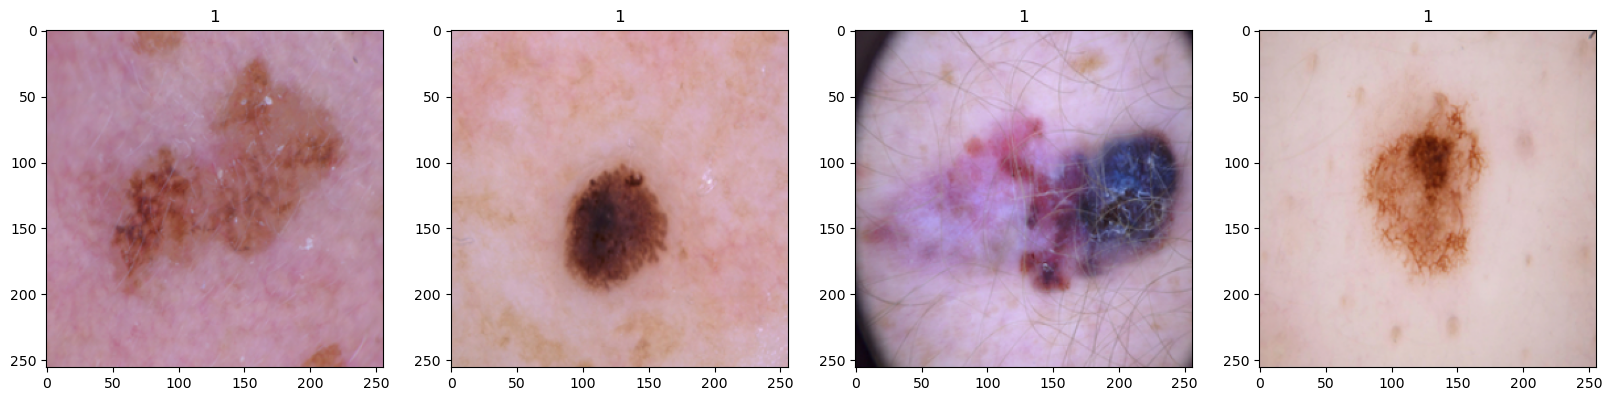

In [46]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [47]:
#data.map allows us to perform the transformation in pipeline in each batch
data = data.map(lambda x,y: (x/255, y))

In [48]:
scaled_iterator = data.as_numpy_iterator()

In [49]:
scaled_iterator.next()[0].max()

0.9998162

# 5. Split Data

In [50]:
#The number of batches 
len(data)

104

In [51]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [52]:
train_size

72

In [53]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [54]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [56]:
model = Sequential()

In [57]:
# [filters], [size of filter], [stride], [activation function], [input shape]
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# Condense the rows & the width, & the number of filters will form the filter value
model.add(Flatten())

# 256 is the number of neurons in the layer
model.add(Dense(256, activation='relu'))
# Final output layer with 1 neuron using sigmiod activation function
model.add(Dense(1, activation='sigmoid'))

In [58]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

# 7. Train

In [60]:
logdir='logs'

In [61]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [62]:
hist = model.fit(train, epochs=60, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/60


2023-01-11 07:59:30.352293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


71/72 [============================>.] - ETA: 0s - loss: 0.5972 - accuracy: 0.6769

2023-01-11 07:59:34.676259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 6s 71ms/step - loss: 0.5972 - accuracy: 0.6766 - val_loss: 0.4693 - val_accuracy: 0.7563
Epoch 2/60
72/72 [==============================] - 5s 66ms/step - loss: 0.4544 - accuracy: 0.7648 - val_loss: 0.4277 - val_accuracy: 0.7828
Epoch 3/60
72/72 [==============================] - 5s 71ms/step - loss: 0.4144 - accuracy: 0.7973 - val_loss: 0.4166 - val_accuracy: 0.7844
Epoch 4/60
72/72 [==============================] - 5s 72ms/step - loss: 0.3880 - accuracy: 0.7995 - val_loss: 0.4128 - val_accuracy: 0.8109
Epoch 5/60
72/72 [==============================] - 5s 69ms/step - loss: 0.3863 - accuracy: 0.8138 - val_loss: 0.4727 - val_accuracy: 0.7766
Epoch 6/60
72/72 [==============================] - 6s 75ms/step - loss: 0.3795 - accuracy: 0.8155 - val_loss: 0.3733 - val_accuracy: 0.8172
Epoch 7/60
72/72 [==============================] - 5s 73ms/step - loss: 0.3692 - accuracy: 0.8238 - val_loss: 0.4227 - val_accuracy: 0.8156
Epoch 8/60
72/72 [======

# 8. Plot Performance

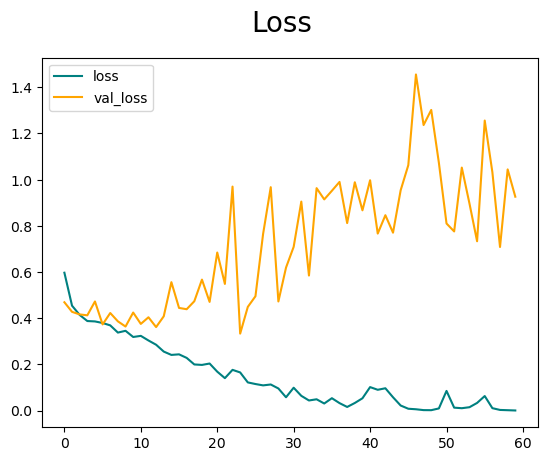

In [63]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

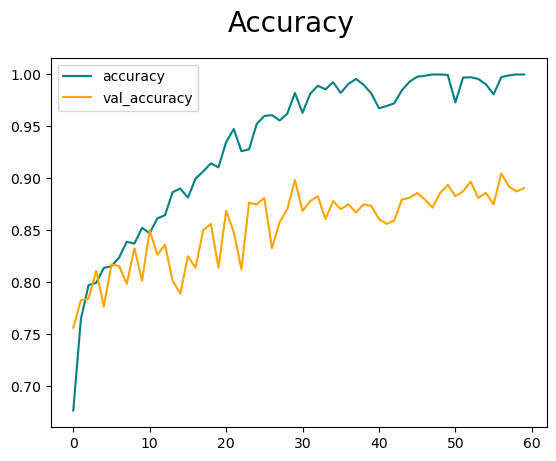

In [64]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [65]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [66]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [67]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 19ms/step


2023-01-11 08:04:29.648335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 23ms/step


In [68]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.8116883039474487, Recall:0.8064516186714172, Accuracy:0.815625011920929


# 10. Test

In [69]:
import cv2

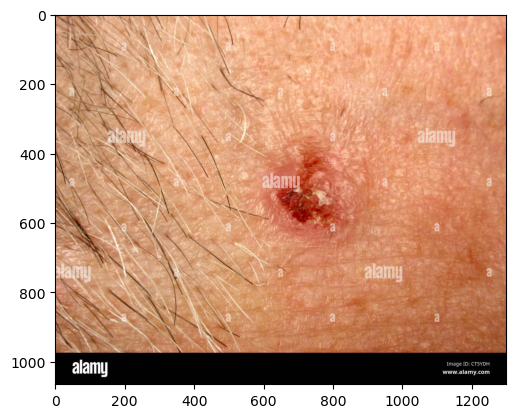

In [71]:
img = cv2.imread('malignant_test.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

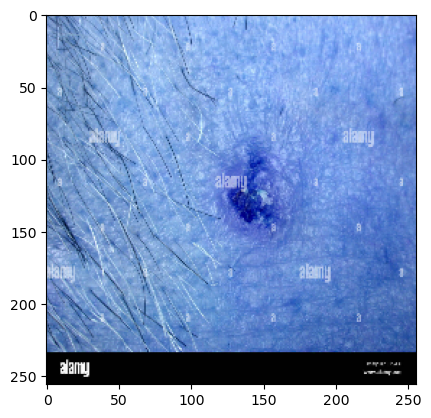

In [72]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [73]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 123ms/step


2023-01-11 08:10:56.650943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [74]:
yhat

array([[1.]], dtype=float32)

In [77]:
if yhat > 0.5: 
    print(f'Predicted as: Malignant Tumor')
else:
    print(f'Predicted as: Benign Tumor')

Predicted as: Malignant Tumor


# 11. Save the Model

This allows the model to be reloaded at a future date.
It also allows the model to be deployed to an API or an Edge Device

In [78]:
from tensorflow.keras.models import load_model

In [79]:
model.save(os.path.join('models','imageclassifier.h5'))

In [80]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))

In [81]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 104ms/step


2023-01-11 08:15:05.489704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [82]:
if yhatnew > 0.5: 
    print(f'Predicted as: Malignant Tumor')
else:
    print(f'Predicted as: Benign Tumor')

Predicted class is Sad


# 12. User Interface Application

In [ ]:
pip install --upgrade gradio

In [83]:
import tensorflow as tf
import gradio as gr

In [85]:
def classify_img(image):
    # img = cv2.imread([image])
    resize = tf.image.resize(image, (256,256))
    yhatnew = new_model.predict(np.expand_dims(resize/255, 0))
    if yhatnew < 0.5: 
        return('Predicted as: Benign Tumor')
    else:
        return('Predicted as: Malignant Tumor')

In [88]:
interface = gr.Interface(fn=classify_img, 
                         inputs=gr.Image(shape=(224, 224)),
                         outputs="text",
                         title="Malignant-Benign Classifier",
                         examples=['malignant_test.jpeg', ' benign_test.jpeg'])

IMPORTANT: You are using gradio version 3.10.0, however version 3.14.0 is available, please upgrade.
--------


In [89]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7866
Running on public URL: https://c7876f9cbb581878.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x31a302c40>,
 'http://127.0.0.1:7866/',
 'https://c7876f9cbb581878.gradio.app')

1/1 [==============================] - 0s 34ms/step
